## Exercises 12: Neural Networks for classification problems

In this notebook we are going to learn how to solve a classification problem exploting neural networks. Namely, our aim is to build a neural network that is able to recognize images picturing digits from $0$ to $9$ giving them the correct label.
<br> The training and validation datasets will consist of images of handwritten digits in grey scale divided into a 28x28 pixel grid. The training dataset will be taken from MNIST dataset as well as the validation dataset for the first and second exercises, while in the third exercise we are going to draw 10 of these pictures and use them to test the network. 
<br> We will first use only dense layers and then add convolutional layers, that can make the network exploit local pattens such as the translation invariance of this case. 

### Exercise 1

In this exercise we are going to work on a given Deep Neural Network and train it in minibatches, adjusting the number of epochs to an adequate value. The network is composed as follows: an input dense layer with $400$ neurons and a ReLU activation function, another dense hidden layer with $100$ neurons and a ReLU activation function, a dropout layer and a final dense layer with $10$ neurons (the number of neurons has to be equal to the number of outputs that is the number of digits we have) and a softmax activation function. The dropout layer is helpful for avoiding overfitting as it randomly turns off some neurons (in this case with probability $0.5$). The softmax activation function of the last layer is useful because it turns the output into a probability: in fact, the output we want consists of the probabilities of being recognized as each one of the labels.

In [ ]:
def create_DNN():         #to give an idea of the network used
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))  #input shape è vettore di 28x28
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5 (cioè probabilità 1/2)
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax')) #attivazione softmax mi rende probabilità le attivazioni delle 10 componenti
    
    return model

I tried training the given DNN with different numbers of epochs ($5$, $15$, $30$, $50$) and different optimizers (SGD, Adam, RMSprop). 
<br> None of the optimizers works well with little numbers of epochs ($5$, $15$).
<br> The Adam optimizer and the RMSprop optimizer don't work well with the default learning rate: with $30$ to $50$ epochs they show an oscillating or growing loss and constant or decreasing accuracy; this a typical situation of overfitting, the DNN has got used to the training data too much. In order not to change or reduce the training dataset, I tried changing the learning rate of both optimizers: with a reduction of this parameter the optimizers start to work well. I found that a good value for this learning rate is $0.0001$ for both (with $0.001$ we still have overfitting). With this modification and a number of epochs equal to $30$, I got a final accuracy of $98.24\%$ for Adam and of $97.80\%$ for RMSprop; the loss for Adam is lower than the loss for RMSprop. Both got all predicted digits right and showed a coherent behaviour of loss and accuracy during training and validation. Namely, both the train and test loss decrease exponentially, with train loss higher than test loss until some amount of epochs; this is due to the dropout that was added to the DNN, as it randomly turns off some neurons during training and it is not active during validation. The accuracy increases logarithmically, with the test accuracy higher than the train accuracy until the same amount of epochs; the reason is the same as before. I also added an early stopping with a factor $5$: it means that when the loss gets worse for more than $5$ epochs the training stops; this should help preventing overfitting. 
<br> The SGD with the same modifications doesn't work so well, especially with a learning rate of $0.0001$ which therefore is way too little. For a learning rate of $0.001$ the predicted digits are all right except for one, and the loss and accuracy behave as seen before, but the final loss and accuracy are worse than the others. Better values were obtained with the default learning rate: the behaviour of loss and accuracy were the same as before, but the final loss was between Adam's and RMSprop's and the final accuracy was $97.95\%$ with $30$ epochs and $98.19\%$ with 50 epochs; these behaviours seem not to show any evidence of overfitting. 
<br> The best DNN seems to be the one with Adams with the modifications I have just explained.

### Exercise 2

Now we are going to choose a different architecture for our neural network, using convolutional layers which let us exploit local patterns such as translation invariance with the introduction of filters. 
<br> I built a CNN adding a MaxPooling2D layer that reduces the dimensions of the feature map after the first Conv2D layer, then I added another Conv2D layer to introduce some filters and again a MaxPooling2D layer. Now that the feature map had reduced dimensions I flattened the data with a Flatten layer and then passed it to a Dense fully connected layer in order to introduce non linearity inside the network, followed by a Dropout layer that randomly turns off neurons in the network and helps avoiding overfitting. The last one is the output layer, which has $10$ neurons that represent the $10$ digits the network has to recognize. 
<br> The construction and training of the network are shown below; the validation set here is taken from the MNIST dataset as well as the training set.

In [8]:
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed --> altrimenti ogni volta ne produce uno diverso e non posso riprodurre i dati
tf.random.set_seed(seed)

In [9]:
from keras.datasets import mnist

# input channels --> grey scale
channels = 1
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data() #60000 immagini 28x28 per il train, 10000 immagini 28x28 per il test

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


In [10]:
# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

print()
print('X_train shape:', X_train.shape) #60000 vettori da 784 componenti
print('Y_train shape:', Y_train.shape) #10000 vettori da 784 componenti


X_train shape: (60000, 28, 28)
Y_train shape: (60000, 10)


In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten

In [5]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

In [11]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space-->not connected to this aspect)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=(img_rows, img_cols, channels)))   # dim. (28,28,1)
    # maxpooling layer to reduce dimensions
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))   # dim. (14,14,1)
    # another convolutional layer
    model.add(Conv2D(10, kernel_size=(5, 5),     # dim. (14,14,1)
                     activation='relu'))
    # maxpooling layer to reduce dimensions
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))   # dim. (7,7,1)
    # flattening the output
    model.add(Flatten())
    # dense layer to introduce non linearity
    model.add(Dense(100, activation='relu'))
    # randomly turn off some neurons
    model.add(Dropout(0.5))
    # output layer with 10 neurons and softmax activation
    model.add(Dense(10, activation='softmax'))
    print('Network created and ready for training!')
              
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['acc'])
    print('Network trained!')
              
    return model

In [12]:
# training parameters
batch_size = 32
epochs = 30

# create the deep conv net
model_CNN=create_CNN()

# train CNN
history = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaliate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Network created and ready for training!
Network trained!
Epoch 1/30
1875/1875 [==============================] - 34s 17ms/step - loss: 0.8048 - acc: 0.7373 - val_loss: 0.2172 - val_acc: 0.9303
Epoch 2/30
1875/1875 [==============================] - 32s 17ms/step - loss: 0.3114 - acc: 0.9061 - val_loss: 0.1440 - val_acc: 0.9534
Epoch 3/30
1875/1875 [==============================] - 32s 17ms/step - loss: 0.2361 - acc: 0.9291 - val_loss: 0.1095 - val_acc: 0.9651
Epoch 4/30
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1937 - acc: 0.9416 - val_loss: 0.0922 - val_acc: 0.9690
Epoch 5/30
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1721 - acc: 0.9489 - val_loss: 0.0823 - val_acc: 0.9733
Epoch 6/30
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1529 - acc: 0.9553 - val_loss: 0.0713 - val_acc: 0.9773
Epoch 7/30
1875/1875 [==============================] - 68s 36ms/step - loss: 0.1381 - acc: 0.9584 - val_loss: 0.0652 - val_acc

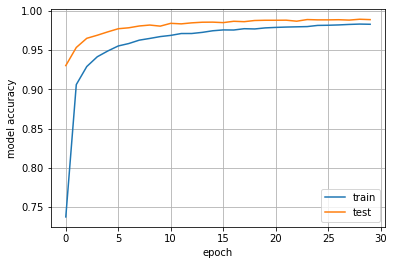

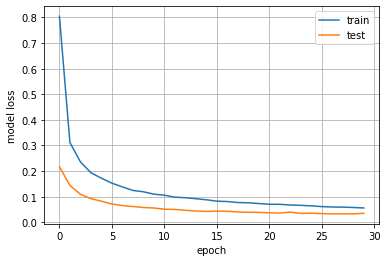

In [13]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

In the figure above, looking into the history of the model, we can see that the behaviour of accuracy and loss is good, as the first one increases logarithmically and the second one decreases exponentially. The fact that test accuracy is always higher than train accuracy and test loss is always lower than train loss is due to the presence of the dropout layer, which randomly turns off neurons during training but is not active during validation. This, in fact, shouldn't be interpreted as evidence of overfitting: the difference between the two losses is higher at the beginning but then decreases to a very little value, which means that the model is improving as time goes on; the high final value of test accuracy ($98.89\%$) is a good sign and means that the model has learned to generalize well.
<br> To see how well the network can make predictions on the validation dataset, we are now going to print each prediction of the model above the image of the digit it has recognize. As follows, the digits have all been correctly guessed by the model.

313/313 [==============================] - 3s 8ms/step


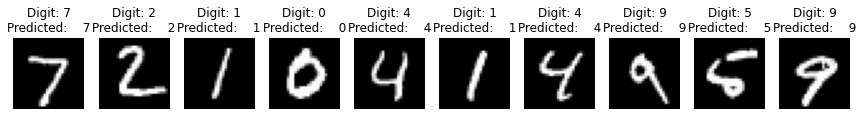

In [14]:
#prendo alcune immagini del dataset e scrivo sia label che predizione che fa

#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

### Exercise 3

Here we are using the same network of exercise 2 and testing it on a different dataset, that is made up of images that I have drawn with Gimp.
<br> After loading the data, we will see what predictions the network makes on it: it turns out that only one guess is not correct, which is a good result regarding the ability of the network to make predictions.

1/1 [==============================] - 0s 40ms/step


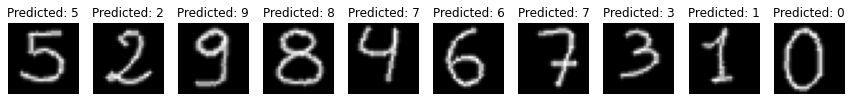

In [43]:
from PIL import Image
import os
import numpy as np

# percorso della cartella contenente le immagini personalizzate
directory = './images/'

# lista per salvare le immagini come array NumPy
gimp_img = []

# ciclo per leggere tutte le immagini nella cartella
for filename in os.listdir(directory):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)
        gimp_img.append(np.array(img))

# converto la lista delle immagini in un array NumPy
gimp_img = np.array(gimp_img)

# aggiungo una dimensione per rappresentare il canale dei colori (scala di grigi, quindi 1)
gimp_img = gimp_img.reshape(-1, 28, 28, 1)

# normalizzo i valori dei pixel nell'intervallo [0, 1]
gimp_img = gimp_img / 255

# faccio predizioni sulle immagini
predictions = model_CNN.predict(gimp_img)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(gimp_img[i, :, :, 0], cmap='gray')    
    plt.title("Predicted: {}".format(np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()